In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# all columns are numerical (categorical columns have been converted)
df = pd.read_csv('df.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df = df.drop(columns=[
    'Late_delivery_risk'
], axis=1)

In [ ]:
df_obj = df.select_dtypes(include='object')
df_obj.drop(columns=['Delivery Status'], axis=1, inplace=True)

In [ ]:
#one hot encoder
def onehotencoder(col):
    
    ohe = OneHotEncoder()
    ohe_array = ohe.fit_transform((pd.DataFrame(col))).toarray()

    feature_labels = np.array(ohe.categories_).ravel()


    df_obj = pd.DataFrame(ohe_array, columns=feature_labels)
    
    return df_obj

In [ ]:
df_ohe = pd.DataFrame()
for c in df_obj.columns:
    one_hot = onehotencoder(df_obj[c])
    df_ohe = pd.concat([df_ohe, one_hot], axis=1) 

In [ ]:
df_cont_var = df.select_dtypes(exclude='object')

In [ ]:
df_ohe = pd.concat([df_cont_var, df_ohe], axis=1)

In [ ]:
df_ohe = pd.concat([df_ohe, df['Delivery Status'] ], axis=1)

In [ ]:
df=df_ohe

In [3]:
# y variable values set equal to label encode the dataframes column being used for y
le = LabelEncoder()
y = le.fit_transform(df['Delivery Status'])

In [4]:
# x variable
X = df.drop(columns=['Delivery Status'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2)

### Random Search

In [6]:
# scaling data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
scaler_x_train = scaler.transform(X_train)

In [8]:
scaler.fit(X_test)
scaler_x_test = scaler.transform(X_test)

#### Random Forest Models

##### Training Model

In [9]:
rf_param_grid={
    'criterion':['gini', 'entropy'],
    'max_depth':[10,70],
    'min_samples_split':[50,100],
    'min_samples_leaf':[1,100],
}

In [10]:
rf = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(rf, rf_param_grid)

rf_rand_search.fit(scaler_x_train, y_train)
rfc_pred_train = rf_rand_search.predict(scaler_x_train)

In [11]:
print(classification_report(y_train, rfc_pred_train, target_names=le.classes_))

                  precision    recall  f1-score   support

Advance shipping       0.70      0.81      0.75       221
   Late delivery       0.72      0.93      0.81       414
Shipping on time       1.00      0.05      0.09       165

        accuracy                           0.71       800
       macro avg       0.81      0.60      0.55       800
    weighted avg       0.77      0.71      0.65       800



In [12]:
print('Mean Absolute Error:', mean_absolute_error(y_train, rfc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, rfc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, rfc_pred_train)))

Mean Absolute Error: 0.345
Mean Squared Error: 0.465
Root Mean Squared Error: 0.6819090848492928


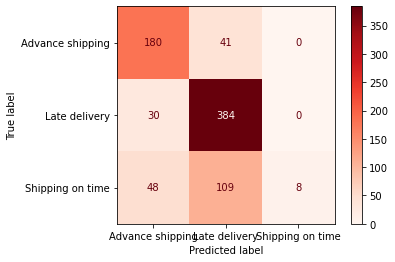

In [13]:
plot_confusion_matrix(rf_rand_search, scaler_x_train, y_train,
                      cmap=plt.cm.Reds)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, )
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

#### Testing Model

In [14]:
rfc_pred_test = rf_rand_search.predict(scaler_x_test)

In [15]:
print(classification_report(y_test, rfc_pred_test, target_names=le.classes_))

                  precision    recall  f1-score   support

Advance shipping       0.49      0.69      0.57        54
   Late delivery       0.69      0.75      0.72       114
Shipping on time       0.00      0.00      0.00        32

        accuracy                           0.61       200
       macro avg       0.39      0.48      0.43       200
    weighted avg       0.53      0.61      0.57       200



In [16]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rfc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, rfc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rfc_pred_test)))

Mean Absolute Error: 0.44
Mean Squared Error: 0.55
Root Mean Squared Error: 0.7416198487095663


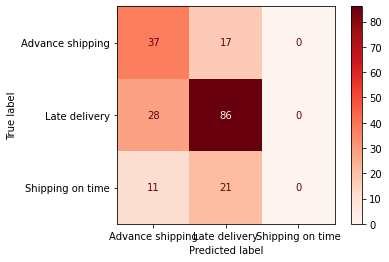

In [17]:
plot_confusion_matrix(rf_rand_search, scaler_x_test, y_test,
                      cmap=plt.cm.Reds)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, )
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

#### XGBoost Models

In [18]:
xgb_param_grid={
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'gamma': [0, 1, 2, 3],
    'max_depth': [20,60],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5, 0.7, 0.9],
}

##### Training Model

In [19]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_rand_search = RandomizedSearchCV(xgb, xgb_param_grid)

xgb_rand_search.fit(scaler_x_train, y_train)
xgb_pred_train = xgb_rand_search.predict(scaler_x_train)

In [20]:
print(classification_report(y_train, xgb_pred_train, target_names=le.classes_))

                  precision    recall  f1-score   support

Advance shipping       1.00      1.00      1.00       221
   Late delivery       1.00      1.00      1.00       414
Shipping on time       1.00      1.00      1.00       165

        accuracy                           1.00       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      1.00      1.00       800



In [21]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgb_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgb_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgb_pred_train)))

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0


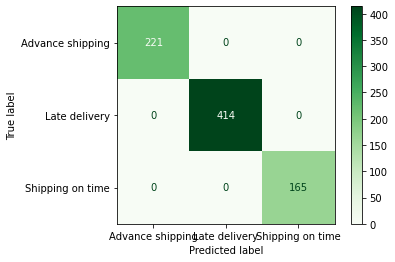

In [22]:
plot_confusion_matrix(xgb_rand_search, scaler_x_train, y_train,
                      cmap=plt.cm.Greens)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_)
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)



plt.show()

##### Testing Model

In [23]:
xgb_pred_test = xgb_rand_search.predict(scaler_x_test)

In [24]:
print(classification_report(y_test, xgb_pred_test, target_names=le.classes_))

                  precision    recall  f1-score   support

Advance shipping       0.54      0.69      0.61        54
   Late delivery       0.76      0.79      0.77       114
Shipping on time       0.62      0.25      0.36        32

        accuracy                           0.68       200
       macro avg       0.64      0.57      0.58       200
    weighted avg       0.68      0.68      0.66       200



In [25]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgb_pred_test)))

Mean Absolute Error: 0.385
Mean Squared Error: 0.505
Root Mean Squared Error: 0.7106335201775947


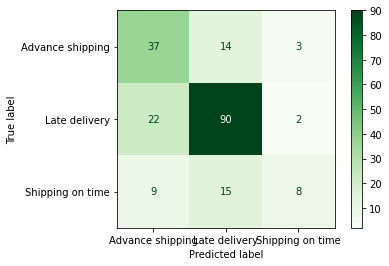

In [26]:
plot_confusion_matrix(xgb_rand_search, scaler_x_test, y_test,
                      cmap=plt.cm.Greens)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, )
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()